In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'../ml')
from customlayers import *

In [19]:
hparams = {'accelerator': 'gpu',
           'devices': [1],
           'dtype': torch.float64,
           'precision': 64,
           'loss': F.mse_loss,
           'optimizer': torch.optim.Adam, 
           'learning_rate': 1e-4,
           'batch_size': 12,
           'max_epochs': 10000,
           'early_stopping_patience': 1000000,
           'modeltype': 'NGO',
           'data_based': True,
           'test_basis': 'POD',
           'trial_basis': 'POD',
           'quadrature': 'Gauss-Legendre',
           'Q': 100,
           'Q_L': 268,
           'h': 64, 
           'bias_NLBranch': False,
           'bias_LBranch': False,
           'NLB_outputactivation': nn.Tanhshrink(),
           'scale_invariance': False,
           'symgroupavg': False}

params = {}
params['hparams'] = hparams

In [506]:
class SPCNN(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hparams = params['hparams']
        self.layers = nn.ModuleList()
        self.kernel_size = 4
        self.num_channels = int(np.sqrt(20000/(2*self.kernel_size**2)))
        
        #Adjusted convolutional layers
        self.layers.append(ReshapeLayer(output_shape=(1,self.hparams['h'],self.hparams['h'])))
        self.layers.append(nn.Conv2d(in_channels=1, out_channels=self.num_channels, kernel_size=self.kernel_size, stride=self.kernel_size, bias=self.hparams.get('bias_NLBranch', True)))
        
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.BatchNorm2d(num_features=self.num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layers.append(nn.Conv2d(in_channels=self.num_channels, out_channels=self.num_channels, kernel_size=self.kernel_size, stride=self.kernel_size, bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.BatchNorm2d(num_features=self.num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layers.append(nn.ConvTranspose2d(in_channels=self.num_channels, out_channels=self.num_channels, kernel_size=self.kernel_size, stride=self.kernel_size, bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.BatchNorm2d(num_features=self.num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        self.layers.append(nn.ConvTranspose2d(in_channels=self.num_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.kernel_size, bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(ReshapeLayer(output_shape=(64,64)))
        if self.hparams['NLB_outputactivation'] is not None:
            self.layers.append(self.hparams['NLB_outputactivation'])

    def forward(self, x):
        for layer in self.layers:
            print(x.shape)
            x = layer(x)
        y = x
        return y

In [507]:
model = SPCNN(params)

In [508]:
sum(p.numel() for p in model.parameters())

20950

In [666]:
K = torch.rand(64,64)
K

tensor([[0.8401, 0.9167, 0.4927,  ..., 0.3464, 0.8347, 0.1061],
        [0.0696, 0.9133, 0.4176,  ..., 0.2108, 0.5455, 0.2378],
        [0.7093, 0.4981, 0.6237,  ..., 0.5547, 0.4962, 0.0275],
        ...,
        [0.7920, 0.6906, 0.3441,  ..., 0.3828, 0.1982, 0.0356],
        [0.9141, 0.0603, 0.3214,  ..., 0.0779, 0.3570, 0.7265],
        [0.4710, 0.7880, 0.6852,  ..., 0.8276, 0.5124, 0.9273]])

In [667]:
rowsort = torch.mean(K, axis=1).argsort()

In [668]:
torch.amax(K, axis=1)

tensor([0.9987, 0.9969, 0.9704, 0.9973, 0.9501, 0.9979, 0.9639, 0.9633, 0.9769,
        0.9878, 0.9789, 0.9930, 0.9922, 0.9905, 0.9943, 0.9904, 0.9932, 0.9595,
        0.9940, 0.9875, 0.9997, 0.9903, 0.9526, 0.9924, 0.9676, 0.9996, 0.9871,
        0.9922, 0.9951, 0.9985, 0.9861, 0.9957, 0.9646, 0.9865, 0.9987, 0.9975,
        0.9837, 0.9989, 0.9779, 0.9816, 0.9988, 0.9934, 0.9920, 0.9849, 0.9730,
        0.9908, 0.9981, 0.9974, 0.9783, 0.9846, 0.9951, 0.9759, 0.9721, 0.9937,
        0.9749, 0.9933, 0.9952, 0.9708, 0.9888, 0.9807, 0.9415, 0.9707, 0.9695,
        0.9895])

In [669]:
rowsort = torch.amax(K, axis=1).argsort().flip(-1)
colsort = torch.amax(K, axis=0).argsort().flip(-1)

In [670]:
K = K[rowsort,:]
K = K[:,colsort]

In [671]:
K

tensor([[0.9997, 0.4654, 0.9695,  ..., 0.2563, 0.7759, 0.1882],
        [0.0222, 0.9996, 0.3739,  ..., 0.0314, 0.3450, 0.3915],
        [0.9461, 0.1044, 0.9989,  ..., 0.4377, 0.8753, 0.7445],
        ...,
        [0.4654, 0.1949, 0.2864,  ..., 0.1797, 0.1340, 0.7887],
        [0.8103, 0.9494, 0.6523,  ..., 0.6362, 0.1494, 0.8328],
        [0.0513, 0.7531, 0.3293,  ..., 0.6534, 0.2089, 0.0851]])

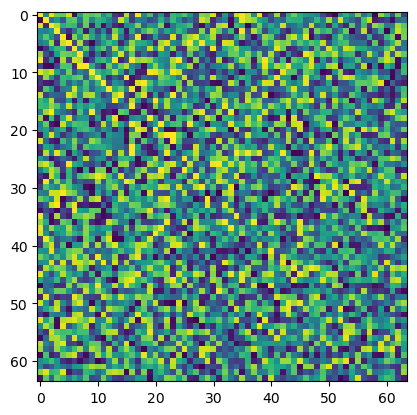

In [672]:
plt.imshow(K)